# Import the libraries

In [1]:
%matplotlib inline
import numpy as np
#for the sigmoid function we need expit() from scipy
import scipy.special
#library for plotting arrays
import matplotlib.pyplot as plt
# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.

import pandas as pd # to manage data frames and reading csv files

# set global variables

In [2]:
#number of input, hidden and output nodes
input_nodes = 784 #we have 28 * 28 matrix to describe each digit
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.3
batch_size = 50

# epochs is the number of training iterations 
epochs = 10

# Splitting the dataset

In [3]:
#splitting the dataset into trainning=80% and test=20%
df = pd.read_csv("mnist.csv")
mn = np.random.rand(len(df)) < 0.8
df_train = df[mn]
df_test = df[~mn]


#return true if no data is missin while spliting
if (df_train.size+df_test.size==df.size):
    print("no data was lost during the splitting process")
if (df_train.size+df_test.size!=df.size):
    print("data was lost during the splitting process")

no data was lost during the splitting process


# Saving the dataset as CSV after splitting

In [4]:
#use index=false so pandas dont create a extra index column
df_train.to_csv('mnist_train.csv',index=False)
df_test.to_csv('mnist_test.csv',index=False)


# Loading the data set

In [5]:

train_file = "mnist_train.csv"
test_file = "mnist_test.csv"

In [6]:
#load the mnist training data CSV file into a list
#train_data_file = open("mnist/mnist_train_100.csv", 'r') # open and read the 100 instances in the text file
train_data_file = open(train_file, 'r')
train_data_list = train_data_file.readlines() # read all lines into memory 
train_data_file.close() 

print("train set size: ", len(train_data_list))

#testing the network
#load the mnist test data CSV file into a list
#test_data_file = open("mnist/mnist_test_10.csv", 'r') # read the file with 10 instances first
test_data_file = open(test_file, 'r') # read the file with 10 instances first
test_data_list = test_data_file.readlines()
test_data_file.close()
print("test set size: ", len(test_data_list))
#print(train_data_list[0])

train set size:  3971
test set size:  1030


# Built Artificial Neural Network class

In [7]:
class neuralNetwork:
    """Artificial Neural Network classifier.

    Parameters
    ------------
    lr : float
      Learning rate (between 0.0 and 1.0)
    ep : int
      Number of epochs for training the network towards achieving convergence
    batch_size : int
      Size of the training batch to be used when calculating the gradient descent. 
      batch_size = 0 standard gradient descent
      batch_size > 0 stochastic gradient descent 

    inodes : int
      Number of input nodes which is normally the number of features in an instance.
    hnodes : int
      Number of hidden nodes in the net.
    onodes : int
      Number of output nodes in the net.


    Attributes
    -----------
    wih : 2d-array
      Input2Hidden node weights after fitting 
    who : 2d-array
      Hidden2Output node weights after fitting 
    E : list
      Sum-of-squares error value in each epoch.
      
    Results : list
      Target and predicted class labels for the test data.
      
    Functions
    ---------
    activation_function : float (between 1 and -1)
        implments the sigmoid function which squashes the node input

    """

    def __init__(self, inputnodes=784, hiddennodes=200, outputnodes=10, learningrate=0.1, batch_size=100, epochs=10):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        #link weight matrices, wih (input to hidden) and who (hidden to output)
        #a weight on link from node i to node j is w_ij
        
        
        #Draw random samples from a normal (Gaussian) distribution centered around 0.
        #numpy.random.normal(loc to centre gaussian=0.0, scale=1, size=dimensions of the array we want) 
        #scale is usually set to the standard deviation which is related to the number of incoming links i.e. 
        #1/sqrt(num of incoming inputs). we use pow to raise it to the power of -0.5.
        #We have set 0 as the centre of the guassian dist.
        # size is set to the dimensions of the number of hnodes, inodes and onodes
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #set the learning rate
        self.lr = learningrate
        
        #set the batch size
        self.bs = batch_size
        
        #set the number of epochs
        self.ep = epochs
        
        #store errors at each epoch
        self.E= []
        
        #store results from testing the model
        #keep track of the network performance on each test instance
        self.results= []
        
        #define the activation function here
        #specify the sigmoid squashing function. Here expit() provides the sigmoid function.
        #lambda is a short cut function which is executed there and then with no def (i.e. like an anonymous function)
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass
    
   
    def batch_input(self, input_list):
        """Yield consecutive batches of the specified size from the input list."""
        for i in range(0, len(input_list), self.bs):
            yield input_list[i:i + self.bs]
    
    #train the neural net
    #note the first part is very similar to the query function because they both require the forward pass
    def train(self, train_inputs):
        """Training the neural net. 
           This includes the forward pass ; error computation; 
           backprop of the error ; calculation of gradients and updating the weights.

            Parameters
            ----------
            train_inputs : {array-like}, shape = [n_instances, n_features]
            Training vectors, where n_instances is the number of training instances and
            n_features is the number of features.
            Note this contains all features including the class feature which is in first position
        
            Returns
            -------
            self : object
        """
      
        for e in range(self.ep):
            print("Training epoch#: ", e)
            sum_error = 0.0   
            for batch in self.batch_input(train_inputs):
                #creating variables to store the gradients   
                delta_who = 0
                delta_wih = 0
                
                # iterate through the inputs sent in
                for instance in batch:
                    # split it by the commas
                    all_values = instance.split(',') 
                    # scale and shift the inputs to address the problem of diminishing weights due to multiplying by zero
                    # divide the raw inputs which are in the range 0-255 by 255 will bring them into the range 0-1
                    # multiply by 0.99 to bring them into the range 0.0 - 0.99.
                    # add 0.01 to shift them up to the desired range 0.01 - 1. 
                    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                    #create the target output values for each instance so that we can use it with the neural net
                    #note we need 10 nodes where each represents one of the digits
                    targets = np.zeros(output_nodes) + 0.01 #all initialised to 0.01
                    #all_value[0] has the target class label for this instance
                    targets[int(all_values[0])] = 0.99
        
                    #convert  inputs list to 2d array
                    inputs = np.array(inputs,  ndmin=2).T
                    targets = np.array(targets, ndmin=2).T

                    #calculate signals into hidden layer
                    hidden_inputs = np.dot(self.wih, inputs)
                    #calculate the signals emerging from the hidden layer
                    hidden_outputs = self.activation_function(hidden_inputs)

                    #calculate signals into final output layer
                    final_inputs=np.dot(self.who, hidden_outputs)
                    #calculate the signals emerging from final output layer
                    final_outputs = self.activation_function(final_inputs)
        
                    #to calculate the error we need to compute the element wise diff between target and actual
                    output_errors = targets - final_outputs
                    #Next distribute the error to the hidden layer such that hidden layer error
                    #is the output_errors, split by weights, recombined at hidden nodes
                    hidden_errors = np.dot(self.who.T, output_errors)
            
                       
                    ## for each instance accumilate the gradients from each instance
                    ## delta_who are the gradients between hidden and output weights
                    ## delta_wih are the gradients between input and hidden weights
                    delta_who += np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
                    delta_wih += np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
                    
                    sum_error += np.dot(output_errors.T, output_errors)#this is the sum of squared error accumilated over each batced instance
                   
                pass #instance
            
                # update the weights by multiplying the gradient with the learning rate
                # note that the deltas are divided by batch size to obtain the average gradient according to the given batch
                # obviously if batch size = 1 then we dont need to bother with an average
                self.who += self.lr * (delta_who / self.bs)
                self.wih += self.lr * (delta_wih / self.bs)
            pass # batch
            self.E.append(np.asfarray(sum_error).flatten())
            print("errors (SSE): ", self.E[-1])
        pass # epoch
    
    #query the neural net
    def query(self, inputs_list):
        #convert inputs_list to a 2d array
        #print(numpy.matrix(inputs_list))
        #inputs_list [[ 1.   0.5 -1.5]]
        inputs = np.array(inputs_list, ndmin=2).T 
        #once converted it appears as follows
        #[[ 1. ]
        # [ 0.5]
        # [-1.5]]
        #print(numpy.matrix(inputs))
        
        #propogate input into hidden layer. This is the start of the forward pass
        hidden_inputs = np.dot(self.wih, inputs)
        
        
        #squash the content in the hidden node using the sigmoid function (value between 1, -1)
        hidden_outputs = self.activation_function(hidden_inputs)
                
        #propagate into output layer and the apply the squashing sigmoid function
        final_inputs = np.dot(self.who, hidden_outputs)
        
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
    
     
    #iterate through all the test data to calculate model accuracy
    def test(self, test_inputs):
        self.results = []
        
        #go through each test instances
        for instance in test_inputs:
            all_values = instance.split(',') # extract the input feature values for the instance
    
            target_label = int(all_values[0]) # get the target class for the instance
    
            #scale and shift the inputs this is to make sure values dont lead to zero when multiplied with weights
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    
            #query the network with test inputs
            #note this returns 10 output values ; of which the index of the highest value
            # is the networks predicted class label
            outputs = self.query(inputs)
    
            #get the index of the highest output node as this corresponds to the predicted class
            predict_label = np.argmax(outputs) #this is the class predicted by the ANN
    
            self.results.append([predict_label, target_label])
            #compute network error
            #if (predict_label == target_label):
            #    self.results.append(1)
            #else: 
            #    self.results.append(0)
            pass
        pass
        self.results = np.asfarray(self.results) # flatten results to avoid nested arrays
    
        
    

# Training the ANN

In [8]:
#create instance of neuralnet
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epochs)

# numpy.random.choice generates a random sample from a given 1-D array
# we can use this to select a sample from our training data in case we want to work with a small sample
# for instance we use a small sample here such as 1500
#mini_training_data = np.random.choice(train_data_list, replace = False)
#print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)
n.train(train_data_list)

Training epoch#:  0
errors (SSE):  [1064.08999158]
Training epoch#:  1
errors (SSE):  [716.83094012]
Training epoch#:  2
errors (SSE):  [631.04268307]
Training epoch#:  3
errors (SSE):  [603.15359719]
Training epoch#:  4
errors (SSE):  [584.37755174]
Training epoch#:  5
errors (SSE):  [566.99145901]
Training epoch#:  6
errors (SSE):  [550.52494675]
Training epoch#:  7
errors (SSE):  [535.05465167]
Training epoch#:  8
errors (SSE):  [521.18923866]
Training epoch#:  9
errors (SSE):  [508.61905347]


# Plot the model error and epochs

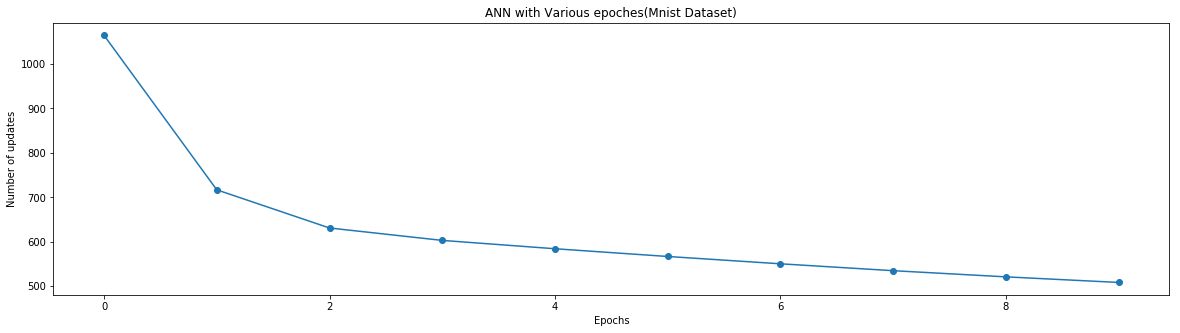

In [9]:
#print the error over epochs
plt.figure(figsize=(20,5)) #width, height settings for figures
plt.plot(range(0, n.ep), np.asfarray(n.E), marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.title('ANN with Various epoches(Mnist Dataset)')
# plt.savefig('images/02_07.png', dpi=300)
plt.show()

# Test the ANN and compute the Accuracy

In [10]:
n.test(test_data_list)

#print network performance as an accuracy metric
correct = 0 # number of predictions that were correct

#iteratre through each tested instance and accumilate number of correct predictions
for result in n.results:
    if (result[0] == result[1]):
            correct += 1
    pass
pass

# print the accuracy on test set
print ("Test set accuracy% = ", (100 * correct / len(n.results)))

Test set accuracy% =  53.300970873786405


# ANN with various epoches

In [11]:
print("This will take a few moments ...")
n_list = []
epochs = [2,5,10,12,15,20]

for epoch in epochs:
    n = neuralNetwork(epochs=epoch)
    n.train(train_data_list)
    n_list.append(n)

This will take a few moments ...
Training epoch#:  0
errors (SSE):  [2196.28780428]
Training epoch#:  1
errors (SSE):  [1597.57626299]
Training epoch#:  0
errors (SSE):  [2011.39332611]
Training epoch#:  1
errors (SSE):  [1538.10511914]
Training epoch#:  2
errors (SSE):  [1298.8473278]
Training epoch#:  3
errors (SSE):  [1191.55670688]
Training epoch#:  4
errors (SSE):  [1127.10065666]
Training epoch#:  0
errors (SSE):  [1961.3459274]
Training epoch#:  1
errors (SSE):  [1557.65385466]
Training epoch#:  2
errors (SSE):  [1319.11735356]
Training epoch#:  3
errors (SSE):  [1205.38525811]
Training epoch#:  4
errors (SSE):  [1136.15026503]
Training epoch#:  5
errors (SSE):  [1086.42883496]
Training epoch#:  6
errors (SSE):  [1047.39178585]
Training epoch#:  7
errors (SSE):  [1015.04798726]
Training epoch#:  8
errors (SSE):  [987.31610543]
Training epoch#:  9
errors (SSE):  [963.01940808]
Training epoch#:  0
errors (SSE):  [2615.18041133]
Training epoch#:  1
errors (SSE):  [1625.93360531]
Tr

# Gather the results from various size of epoches

In [12]:
#iteratre through each model and accumilate number of correct predictions
model_results = []
for model in n_list: 
    correct = 0
    model.test(test_data_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    model_results.append(correct)
    print(correct)
    pass
pass

24.854368932038835
52.42718446601942
69.80582524271844
72.42718446601941
72.62135922330097
76.11650485436893


# Plot the results from various size of epoches

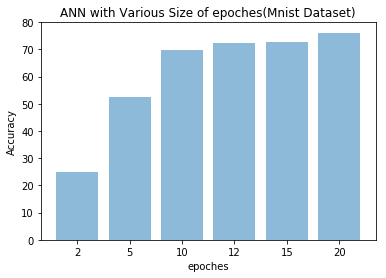

In [13]:
objects =epochs 
y_pos = np.arange(len(objects))
performance = model_results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.xlabel('epoches')
plt.title('ANN with Various Size of epoches(Mnist Dataset)')
 
plt.show()

# ANN with various Batch_size

In [14]:
# numpy.random.choice generates a random sample from a given 1-D array
# we can use this to select a sample from our training data in case we want to work with a small sample
# for instance we use a small sample here such as 1500
#mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
#print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)

print("This will take a few moments ...")
n_list = []
batch_sizes = [1, 100, 1000, 2000, 3000,len(train_data_list)]

for batch_size in batch_sizes:
    n = neuralNetwork(batch_size=batch_size)
    n.train(train_data_list)
    n_list.append(n)

This will take a few moments ...
Training epoch#:  0
errors (SSE):  [35.2707893]
Training epoch#:  1
errors (SSE):  [39.32874715]
Training epoch#:  2
errors (SSE):  [37.16315936]
Training epoch#:  3
errors (SSE):  [32.87315655]
Training epoch#:  4
errors (SSE):  [29.19757018]
Training epoch#:  5
errors (SSE):  [26.26935392]
Training epoch#:  6
errors (SSE):  [23.87714384]
Training epoch#:  7
errors (SSE):  [21.86499264]
Training epoch#:  8
errors (SSE):  [20.26368627]
Training epoch#:  9
errors (SSE):  [18.85808928]
Training epoch#:  0
errors (SSE):  [2409.55881345]
Training epoch#:  1
errors (SSE):  [1712.94772141]
Training epoch#:  2
errors (SSE):  [1408.95341294]
Training epoch#:  3
errors (SSE):  [1266.84106193]
Training epoch#:  4
errors (SSE):  [1184.32405649]
Training epoch#:  5
errors (SSE):  [1126.8692778]
Training epoch#:  6
errors (SSE):  [1082.36690065]
Training epoch#:  7
errors (SSE):  [1045.7416177]
Training epoch#:  8
errors (SSE):  [1014.50871371]
Training epoch#:  9
e

# Gather the test result for each ANN

In [15]:
#iteratre through each model and accumilate number of correct predictions
model_results = []
for model in n_list: 
    correct = 0
    model.test(test_data_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    model_results.append(correct)
    print(correct)
    pass
pass


12.427184466019417
68.54368932038835
75.4368932038835
68.83495145631068
70.67961165048544
51.165048543689316


# Plot the results 

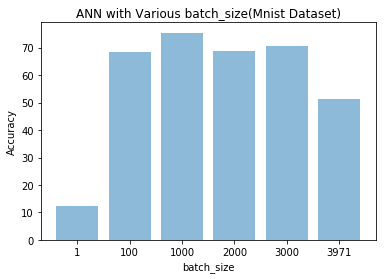

In [16]:
objects = batch_sizes
y_pos = np.arange(len(objects))
performance = model_results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('batch_size')
plt.ylabel('Accuracy')
plt.title('ANN with Various batch_size(Mnist Dataset)')
 
plt.show()

# ANN with various learning rate

In [17]:
# numpy.random.choice generates a random sample from a given 1-D array
# we can use this to select a sample from our training data in case we want to work with a small sample
# for instance we use a small sample here such as 1500
#mini_training_data = np.random.choice(train_data_list, 1500, replace = False)
#print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)

print("This will take a few moments ...")
n_list = []
learning_rates = [0.1,0.2,0.3,0.4,0.6,0.8,1.0]

for learn in learning_rates:
    n = neuralNetwork(learningrate = learn, batch_size=100)
    n.train(train_data_list)
    n_list.append(n)

This will take a few moments ...
Training epoch#:  0
errors (SSE):  [2474.1249797]
Training epoch#:  1
errors (SSE):  [1653.32270522]
Training epoch#:  2
errors (SSE):  [1363.9113716]
Training epoch#:  3
errors (SSE):  [1228.07212873]
Training epoch#:  4
errors (SSE):  [1144.66755507]
Training epoch#:  5
errors (SSE):  [1086.56908037]
Training epoch#:  6
errors (SSE):  [1042.43938845]
Training epoch#:  7
errors (SSE):  [1006.88079515]
Training epoch#:  8
errors (SSE):  [977.07282874]
Training epoch#:  9
errors (SSE):  [951.40233765]
Training epoch#:  0
errors (SSE):  [1920.17137769]
Training epoch#:  1
errors (SSE):  [1422.03393515]
Training epoch#:  2
errors (SSE):  [1165.5867261]
Training epoch#:  3
errors (SSE):  [1052.78393506]
Training epoch#:  4
errors (SSE):  [992.58523715]
Training epoch#:  5
errors (SSE):  [952.72908423]
Training epoch#:  6
errors (SSE):  [922.08750452]
Training epoch#:  7
errors (SSE):  [896.71949236]
Training epoch#:  8
errors (SSE):  [874.95276715]
Training

# gathering the results from various learing rate ANN

In [18]:
#iteratre through each model and accumilate number of correct predictions
model_results = []
for model in n_list: 
    correct = 0
    model.test(test_data_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    model_results.append(correct)
    print(correct)
    pass
pass


# print the accuracy on test set
#print ("Test set accuracy% = ", (100 * correct / len(n.results)))

67.66990291262135
65.53398058252428
64.85436893203882
62.33009708737865
62.23300970873786
60.09708737864078
59.6116504854369


# Plotting the accuray from Various learning rate

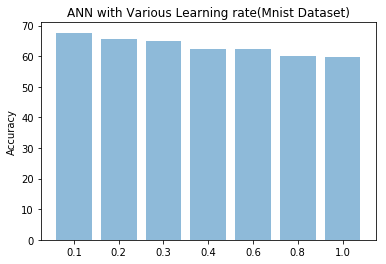

In [19]:
objects = learning_rates
y_pos = np.arange(len(objects))
performance = model_results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Learning_rate')
plt.title('ANN with Various Learning rate(Mnist Dataset)')
 
plt.show()